# Image Segmentation using K-Means Clustering &amp; Gaussian Mixture Model

In [1]:
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from scipy.stats import multivariate_normal
from IPython.core.display import HTML

In [2]:
# Function to get array of pixels of an image
def get_pixels_image(image_path):
    image = Image.open(image_path)
    display(image)
    img_arr = np.asarray(image)
    pixels = img_arr.reshape((-1, 3))
    return pixels, image

# Function to display colors
def display_colors(colors):
    s=''
    for color in colors:
        s+=f'<div style="background-color:rgb({int(color[0])},{int(color[1])},{int(color[2])}); display:inline-block; margin:2px; border:2px solid #888; height:50px; width:50px;"></div>'
    display(HTML(s))

# Function to perform Image segementation
def get_segmented_image(image, Y, mu):
    Y_ = np.zeros((Y.shape[0], 3))
    display_colors(mu)
    for ki, m in enumerate(mu):
        Y_[(Y==ki)[:,0]] = m
    return Image.fromarray(Y_.reshape(np.asarray(image).shape).astype(np.uint8))

### K-Means Clustering

In [3]:
class KMeansClustering:
    def __init__(self, k=2, random_state=None, max_iter = 100):
        self.k = k
        self.random_state = random_state
        self.max_iter = max_iter
    
    def fit_predict(self, X):
        if self.random_state!=None: np.random.seed(self.random_state)
        centroids = np.random.randint(np.amin(X), np.amax(X), (self.k, X.shape[1])).astype(float)
        old_centroids = None
        pred = np.asarray([])
        iteration = 0
        for iteration in range(1, self.max_iter+1):
            X_m = []
            for centroid in centroids:
                X_m.append(((centroid - X)**2).sum(axis=1))
            X_m = np.asarray(X_m)
            pred = np.argmin(X_m, axis=0)
            for i in range(self.k):
                Xi = X[pred==i]
                if len(Xi)>0:
                    centroids[i] = Xi.mean(axis=0)
            if (centroids==old_centroids).all(): break
            old_centroids = centroids.copy()
        self.iterations_made = iteration
        self.centroids = centroids
        return pred.reshape(-1, 1)

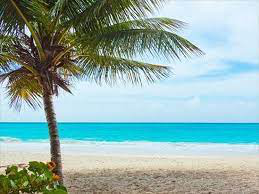


k = 2 
No. of iterations: 10


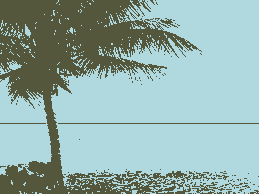


k = 5 
No. of iterations: 50


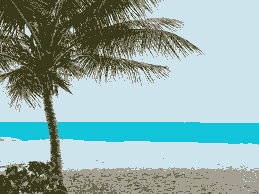


k = 7 
No. of iterations: 46


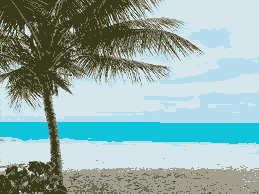

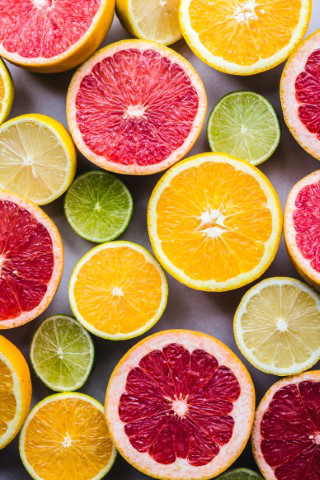


k = 6 
No. of iterations: 41


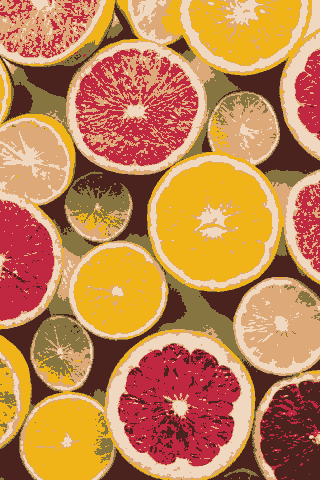

In [4]:
# Example 1
pixels, image = get_pixels_image('beach.jpeg')

k = 2
kmeans = KMeansClustering(k, random_state = 10)
Y = kmeans.fit_predict(pixels)
mu = np.asarray(kmeans.centroids)
print('\nk =', k, '\nNo. of iterations:', kmeans.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)

k = 5
kmeans = KMeansClustering(k, random_state = 10)
Y = kmeans.fit_predict(pixels)
mu = np.asarray(kmeans.centroids)
print('\nk =', k, '\nNo. of iterations:', kmeans.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)

k = 7
kmeans = KMeansClustering(k, random_state = 10)
Y = kmeans.fit_predict(pixels)
mu = np.asarray(kmeans.centroids)
print('\nk =', k, '\nNo. of iterations:', kmeans.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)

# Example 2
print('\n\n')
pixels, image = get_pixels_image('citrus.jpg')
k = 6
kmeans = KMeansClustering(k, random_state = 100)
Y = kmeans.fit_predict(pixels)
mu = np.asarray(kmeans.centroids)
print('\nk =', k, '\nNo. of iterations:', kmeans.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)

### Gaussian Mixture Model

In [5]:
class GMMClustering:
    def __init__(self, k=2, random_state=None, max_iter=100):
        self.k = k
        self.random_state = random_state
        self.max_iter = max_iter

    def _initialize(self, X):
        k = self.k
        self.phi = np.full(shape=k, fill_value=1/k)
        self.weights = np.full(shape=X.shape, fill_value=1/k)
        if self.random_state!=None: np.random.seed(self.random_state)
        random_row = np.random.randint(low=0, high=X.shape[0], size=k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for _ in range(k)]

    def predict(self, X):
        k = self.k
        likelihood = np.zeros((X.shape[0], k))
        for i in range(k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            dpdf = distribution.pdf(X)
            likelihood[:,i] = dpdf
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        self.weights = numerator / denominator
        maxarg = np.argmax(self.weights, axis=1)
        return maxarg

    def _expectation(self, X):
        perm_pred_target = self.predict(X)
        self.phi = self.weights.mean(axis=0)
        return perm_pred_target
    
    def _maximisation(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            tmp_wghts = (weight/total_weight).flatten()
            self.sigma[i] = np.cov(X.T, aweights= tmp_wghts, bias=True)

    def fit_predict(self, X):
        self._initialize(X)
        old_pred = pred = np.asarray([])
        k = self.k
        iteration = 0
        for iteration in range(1, self.max_iter+1):
            pred = self._expectation(X)
            self._maximisation(X)
            if np.array_equiv(old_pred, pred):
                break
            old_pred = pred
        self.iterations_made = iteration
        return pred.reshape(-1, 1)

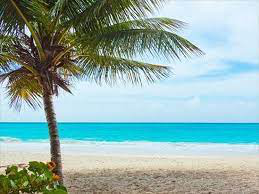


k = 2 
No. of iterations: 19


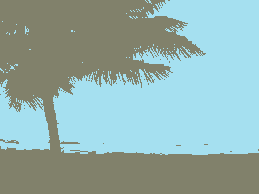


k = 5 
No. of iterations: 100


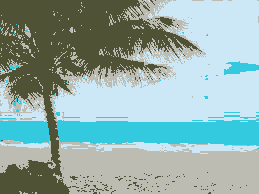


k = 7 
No. of iterations: 100


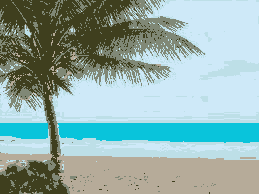

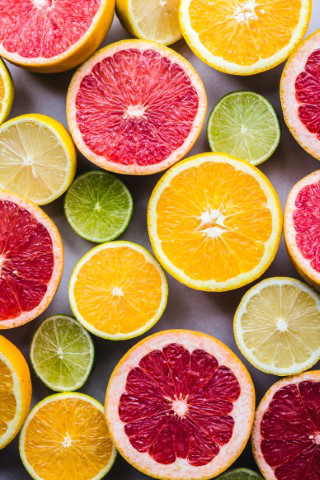


k = 6 
No. of iterations: 100


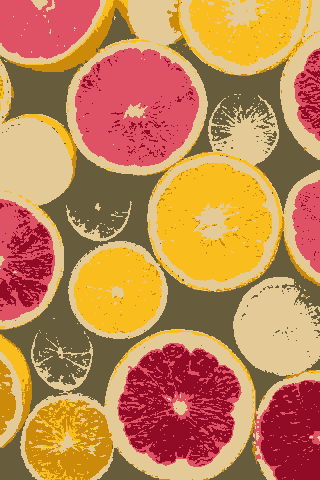

In [6]:
# Example 1
pixels, image = get_pixels_image('beach.jpeg')

k = 2
gmm = GMMClustering(k, random_state = 10)
Y = gmm.fit_predict(pixels)
mu = np.asarray(gmm.mu)
print('\nk =', k, '\nNo. of iterations:', gmm.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)

k = 5
gmm = GMMClustering(k, random_state = 10)
Y = gmm.fit_predict(pixels)
mu = np.asarray(gmm.mu)
print('\nk =', k, '\nNo. of iterations:', gmm.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)

k = 7
gmm = GMMClustering(k, random_state = 10)
Y = gmm.fit_predict(pixels)
mu = np.asarray(gmm.mu)
print('\nk =', k, '\nNo. of iterations:', gmm.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)

# Example 2
print('\n\n')
pixels, image = get_pixels_image('citrus.jpg')
k = 6
gmm = GMMClustering(k, random_state = 150)
Y = gmm.fit_predict(pixels)
mu = np.asarray(gmm.mu)
print('\nk =', k, '\nNo. of iterations:', gmm.iterations_made)
segmented_image = get_segmented_image(image, Y, mu)
display(segmented_image)